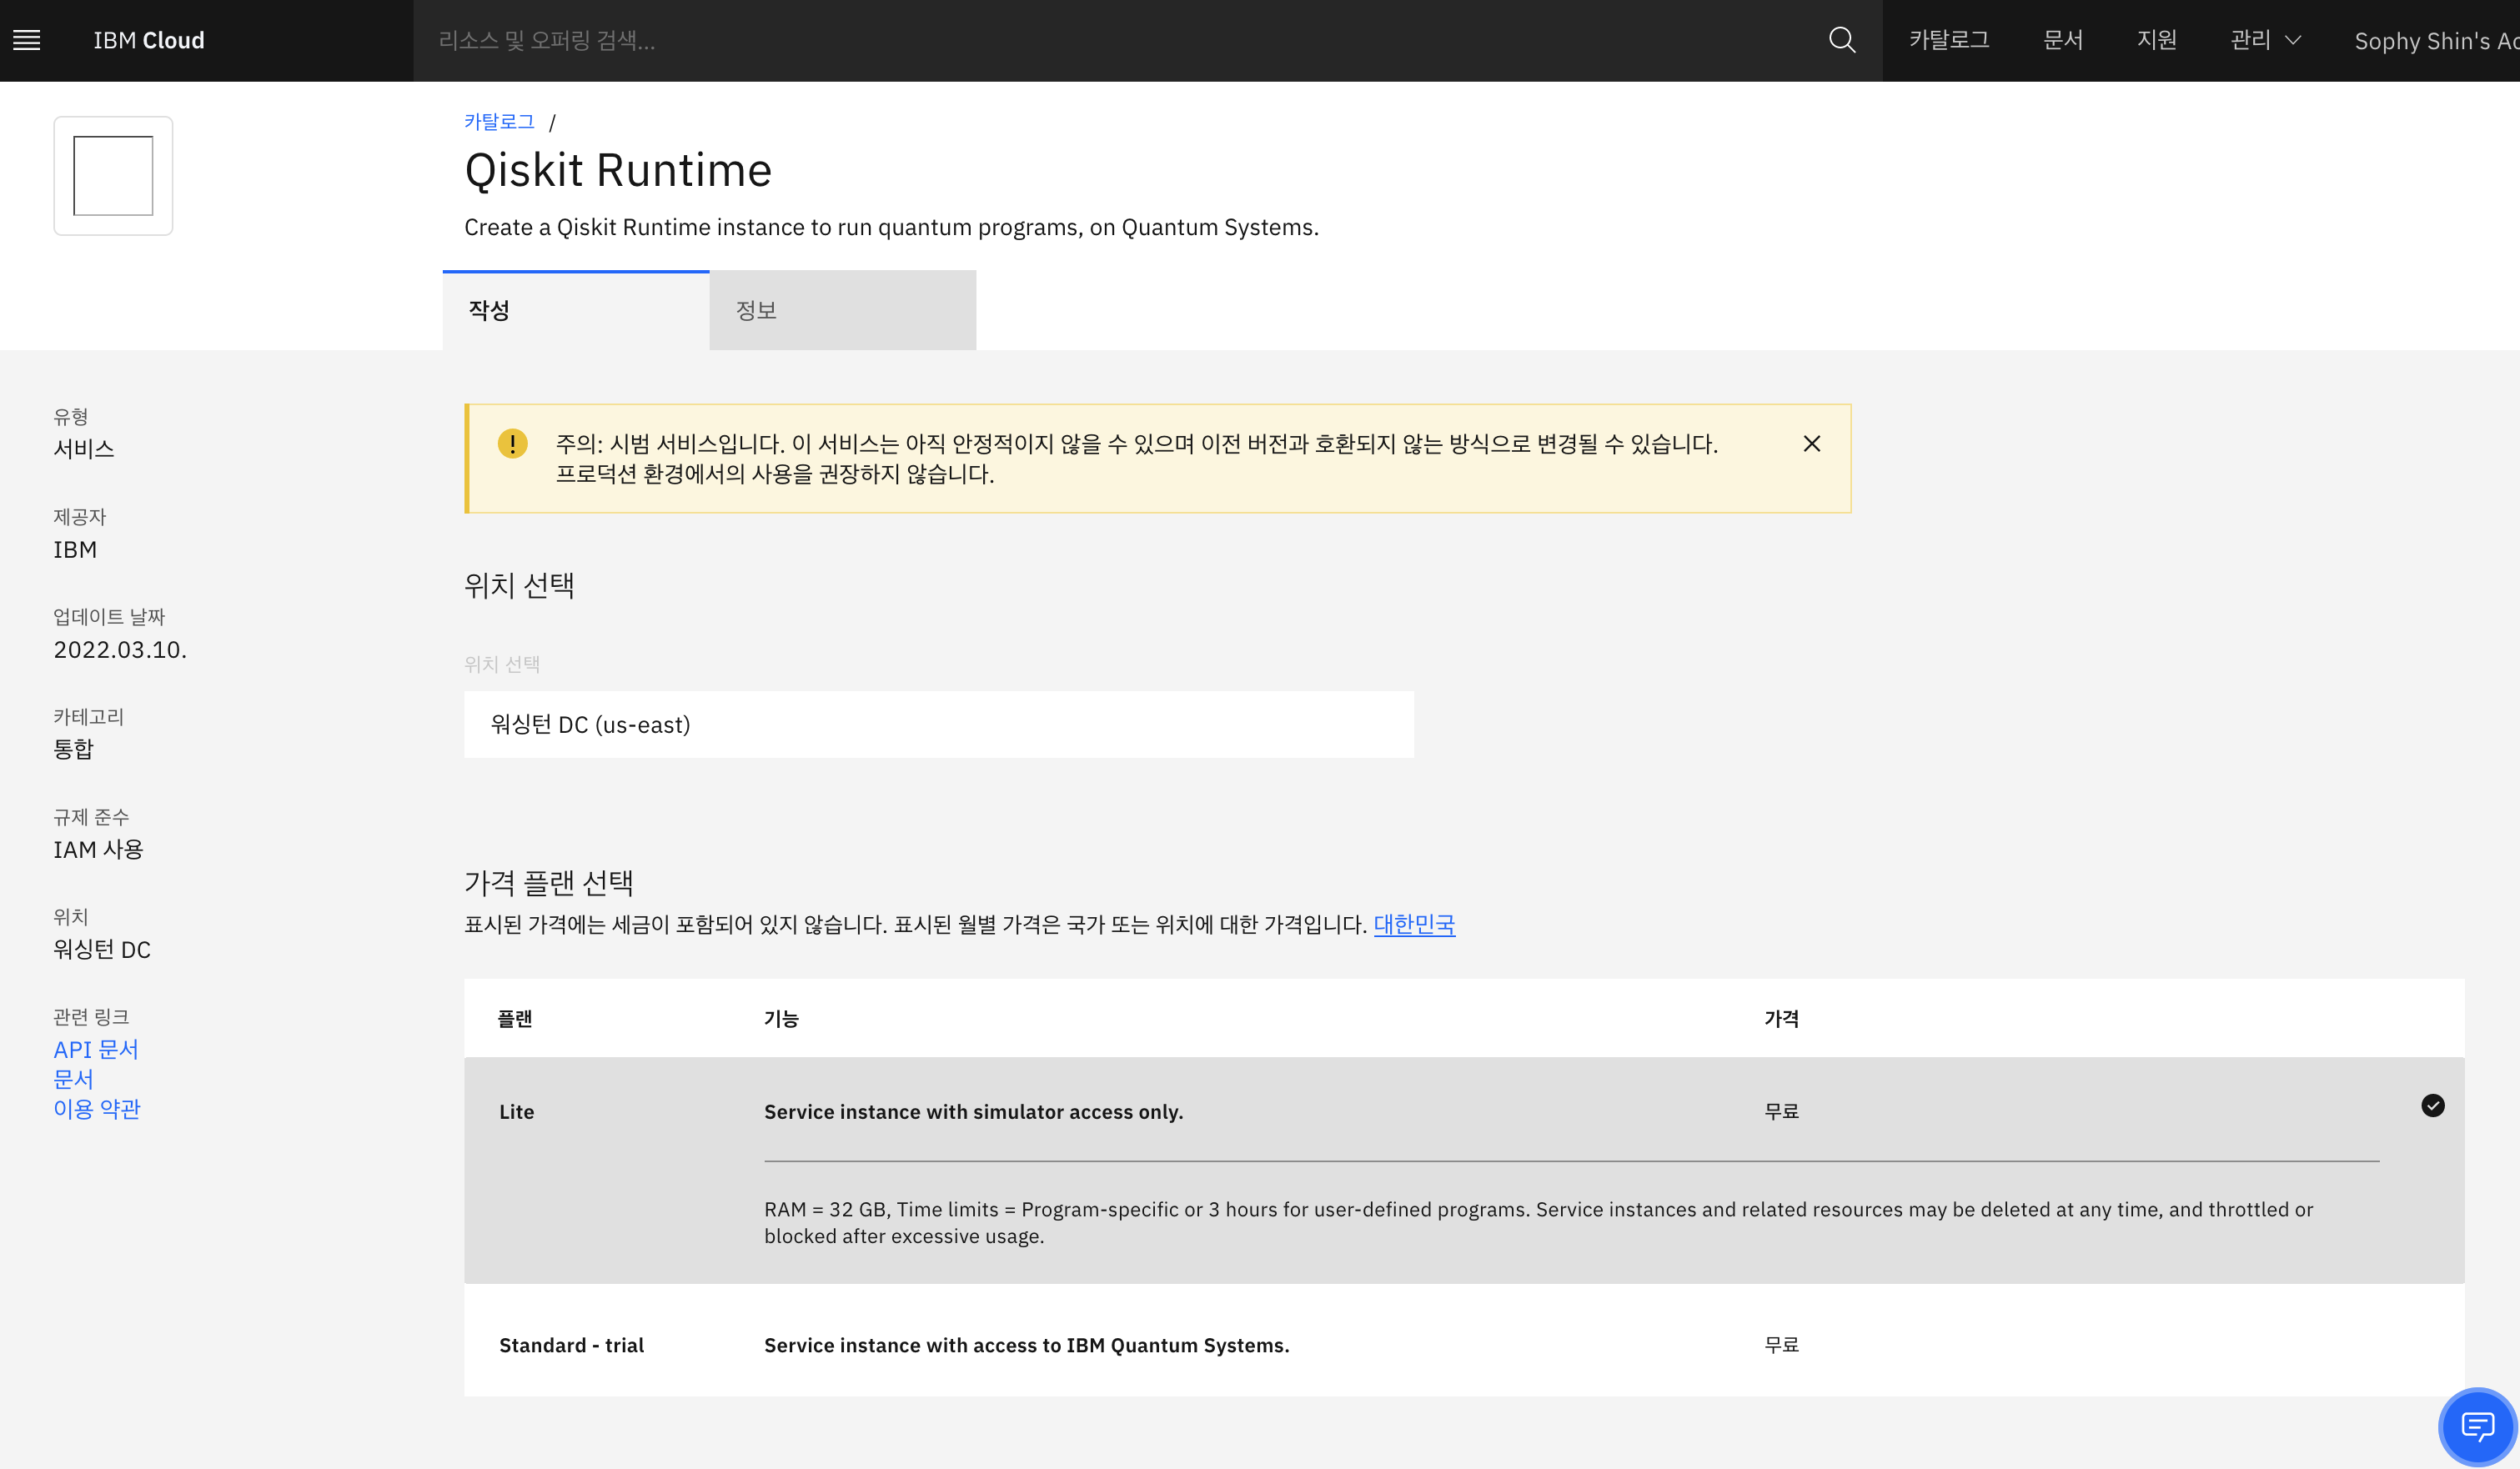

In [1]:
from IPython.display import Image
Image("runtime.png")

## Cloud Qiskit Runtime을 사용해

### 1. 설치 및 테스트 프로그램 실행

#### At IBM Cloud
- 서비스 인스턴스 생성: IBM Quantum Services Provisioning 페이지에서 Lite플랜을 선택하여 서비스 인스턴트를 생성합니다.
- 계정 정보 메모: 
 - [IBM Cloud API keys page](https://cloud.ibm.com/iam/apikeys)에서 여러분의 api키를 복사해 둡니다. 보통 다음과 같은 형식입니다: 

``` I9sxojrwurPrMWqNR_wc4rztMgVqE1HUmsfACMyw_G9n ```
 - 여러분의 Cloud Resource Name (CRN)을 복사해 둡니다. CRN은 리소스 페이지의 "Service and software"에서 생성한 인스턴스 이름을 클릭해 들어가면 확인 할 수 있으며 다음과 같은 형식을 갖습니다.
 
```crn:v1:bluemix:public:quantum-computing:us-east:a/b947c1c5a9378d64aed96696e4d76e8e:a3a7f181-35aa-42c8-94d6-7c8ed6e1a94b::```

#### At Local
Qiskit Runtime을 실행하기 위해 Jupyter notebook을 설치합니다. Anaconda를 사용하는 것을 권장합니다. Qiskit 설치에 대한 자세한 가이드는 다음의 유튜브 및 [Qiskit Hackathon Korea 2022의 설치 가이드](https://github.com/qiskit-community/qiskit-hackathon-korea-22/blob/main/preparation%26installation.md)를 참고합니다.



In [2]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/1kRfHNUbkrg?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


/Users/sophy/opt/anaconda3/envs/runtime/lib/python3.9/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Qiskit Runtime 실행에 필요한 라이브러리를 설치합니다.

In [4]:
#!pip install 'qiskit[all]'
#!pip install qiskit-ibm-runtime
#!pip install matplotlib
#!pip install pylatexenc


Jupyter notebook을 실행하고 Qiskit Runtime이 잘 설치되었는지 필수 라이브러리를 호출해 봅니다. 우선 Lite plan으로 가입한 계정 정보를 사용하겠습니다.

In [3]:
from qiskit_ibm_runtime import IBMRuntimeService

# Save account on disk. if you need to overwrite the account info, please add overwrite=True)
IBMRuntimeService.save_account(auth="cloud", token="Your Token", instance="your_crn", overwrite=True)

service = IBMRuntimeService()

계정정보는 첫 실행시 한번만 저장하면 됩니다. 

`pprint_programs()`를 사용해 사용할 수있는 Qiskit Runtime 프로그램의 목록을 확인해봅시다.

In [4]:
service.pprint_programs()

hello-world:
  Name: hello-world
  Description: Get started by running this simple test program.
sampler:
  Name: sampler
  Description: Generates quasi-probabilities by sampling quantum circuits.
estimator:
  Name: estimator
  Description: Calculates expectation values of quantum operators.


사용할 수 있는 백엔드의 목록을 확인한 후 간단한 hello-world　프로그램을 실행해 봅시다.

In [5]:
service.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>]

In [6]:
from qiskit.test.reference_circuits import ReferenceCircuits

program_inputs = {'iterations': 1}
options = {"backend_name": "ibmq_qasm_simulator"}
job = service.run(program_id="hello-world",
                  #options=options,
                  inputs=program_inputs
                 )
print(f"job id: {job.job_id}")
result = job.result()
print(result)

job id: c8snmd31g19538lodscg
All done!


### 2. Running Sample Circuit

IBM Cloud의 라이트 플랜을 사용하여 간단한 샘플 회로를 돌려봅시다.

아주 간단한 10 qubit, entangled 회로를 작성해 보겠습니다.

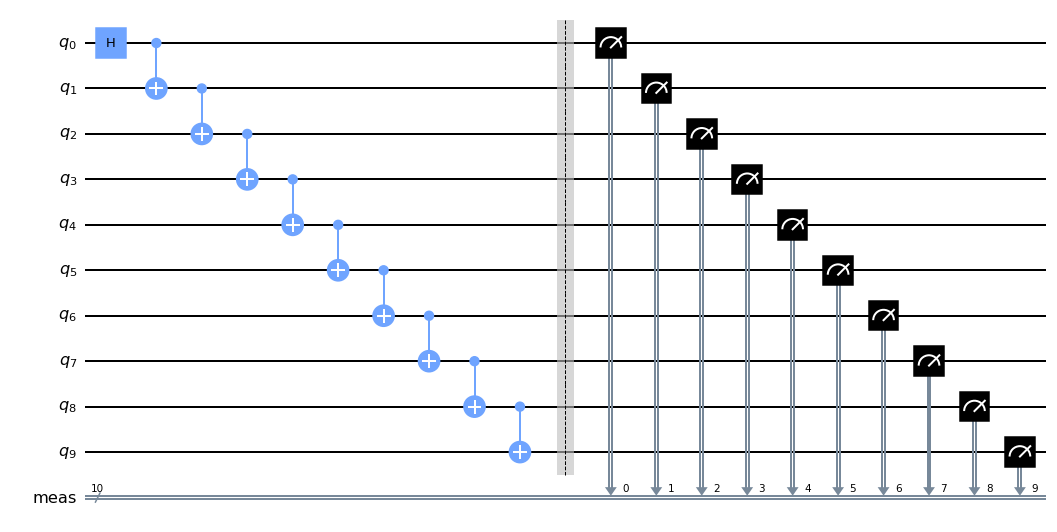

In [7]:
from qiskit import QuantumCircuit

N = 10
qc = QuantumCircuit(N)

qc.h(0)

for kk in range(0, N -1):
    qc.cx(kk, kk + 1)

qc.measure_all()
qc.draw('mpl', fold=-1)

위 회로의 노이즈가 없는 이상적인 결과는 다음과 같습니다. 이 계산은 Aer simulator의 statevector simulator를 사용하는 로컬 계산 결과입니다.

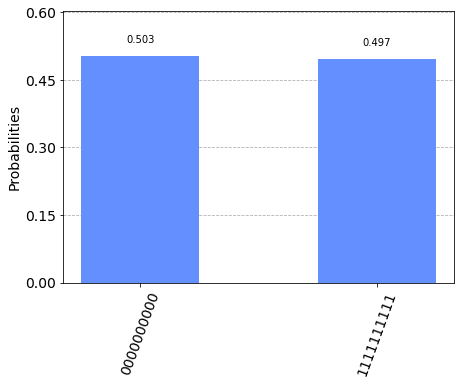

In [8]:
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram


simulator = Aer.get_backend('aer_simulator_statevector')
circ = transpile(qc, simulator)

job_statevector = simulator.run(circ, shots=20000)
counts_statevector = job_statevector.result().get_counts(0)
plot_histogram(counts_statevector)

이 회로를 IBM Quantum Device들 중 가장 높은 QV를 가진 장비중 하나인 Montreal의 특성을 지닌 Fake Backend에서 계산해 봅시다. 이 계산도 로컬 계산 결과입니다.

In [9]:
from qiskit.test.mock import FakeMontreal
fake_backend = FakeMontreal()

In [10]:
from qiskit.tools.jupyter import *
fake_backend

<FakeMontreal('fake_montreal')>

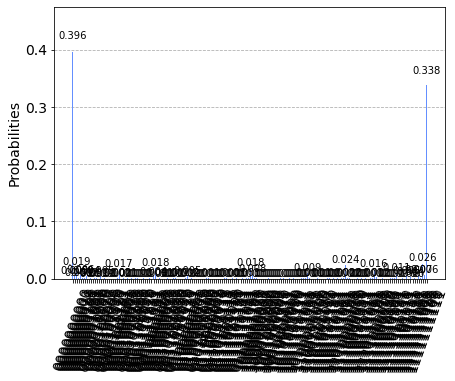

In [11]:
job_noisy = fake_backend.run(circ, shots=20000)
counts_moisy = job_noisy.result().get_counts(0)
plot_histogram(counts_moisy)

이제 이 회로를 Qiskit Runtime을 사용해 측정해 봅시다.
Sampler primitive는 입력한 회로에 대해 각 상태가 측정될 확률을 기본적인 error mitigation이 적용된 값으로 반환합니다. 

In [12]:
service = IBMRuntimeService()
# Specify the program inputs here.
program_inputs = {
    "circuits": qc,
    "circuit_indices": [0],
#    "shots":20000
}

# Specify the backend name.

job = service.run(
    program_id="sampler",
    inputs=program_inputs,
)

# Printing the job ID in case we need to retrieve it later.
print(f"Job ID: {job.job_id}")

# Get the job result - this is blocking and control may not return immediately.
result = job.result()
print(result)

Job ID: c8snni4q5e89nrvbeaug
{'quasi_dists': [{'0000000000': 0.486328125, '1111111111': 0.513671875}], 'metadata': [{'header_metadata': None, 'shots': 1024}]}


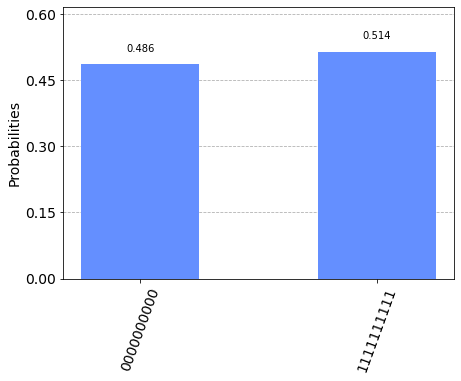

In [13]:
plot_histogram(result.get('quasi_dists'))

이번에는 백엔드를 지정하여 계산해 봅시다. 

In [14]:
# Specify the program inputs here.
program_inputs = {
    "circuits": qc,
    "circuit_indices": [0],
#    "shots":2048
}

# Specify the backend name.
options = {"backend_name": "ibmq_qasm_simulator"}

job = service.run(
    program_id="sampler",
    options=options,
    inputs=program_inputs,
)

# Printing the job ID in case we need to retrieve it later.
print(f"Job ID: {job.job_id}")

# Get the job result - this is blocking and control may not return immediately.
qasm_result = job.result()
print(qasm_result)

Job ID: c8snnmurpjuo8uetd470
{'quasi_dists': [{'0000000000': 0.4921875, '1111111111': 0.5078125}], 'metadata': [{'header_metadata': None, 'shots': 1024}]}


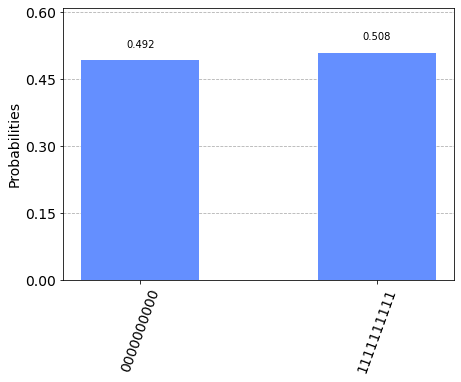

In [16]:
plot_histogram(qasm_result.get('quasi_dists'))

### 3. Running Sample Circuit on a real device

실제 양자백엔드에서 계산을 해보기 위해 계정을 스탠다드 플랜으로 변경해보겠습니다.


In [17]:
IBMRuntimeService.save_account(auth="cloud", token="your token", instance="your _ crn", overwrite=True)


In [18]:
service = IBMRuntimeService()
service.backends()

[<IBMBackend('ibm_algiers')>, <IBMBackend('ibm_canberra')>]

In [22]:
# Specify the program inputs here.
program_inputs = {
    "circuits": qc,
    "circuit_indices": [0],
#    "shots":10000
}

# Specify the backend name.
options = {"backend_name": "ibm_algiers"}

job = service.run(
    program_id="sampler",
    options=options,
    inputs=program_inputs,
)

# Printing the job ID in case we need to retrieve it later.
print(f"Job ID: {job.job_id}")

# Get the job result - this is blocking and control may not return immediately.
real_result = job.result()
print(real_result)

Job ID: c8snqkmrpjuo8uetd4a0
{'quasi_dists': [{'0000000000': 0.31075, '0000000001': 0.02875, '0000010000': 0.004, '0100000000': 0.00125, '0100000001': 0.00025, '0000010001': 0.0005, '0100010000': 0.00025, '0100011111': 0.00025, '0000010011': 0.0005, '0100111111': 0.0005, '0000010101': 0.0005, '0101110111': 0.00025, '0101111111': 0.00075, '0000011000': 0.001, '0110000111': 0.00025, '0110011111': 0.0005, '0110100000': 0.00025, '0000011011': 0.00075, '0110111101': 0.00025, '0110111111': 0.00175, '0111000001': 0.00025, '0000011101': 0.00025, '0111011000': 0.00025, '0111011111': 0.00025, '0000011110': 0.00125, '0111100000': 0.0005, '0111101110': 0.00025, '0111101111': 0.00025, '0000011111': 0.00725, '0111110000': 0.00025, '0111111000': 0.00025, '0111111001': 0.00025, '0111111101': 0.0005, '0111111110': 0.00025, '0111111111': 0.00425, '0000000010': 0.00925, '0000100000': 0.003, '1000000000': 0.005, '1000000001': 0.00025, '1000000010': 0.00025, '1000000100': 0.00025, '1000000111': 0.0005, '10

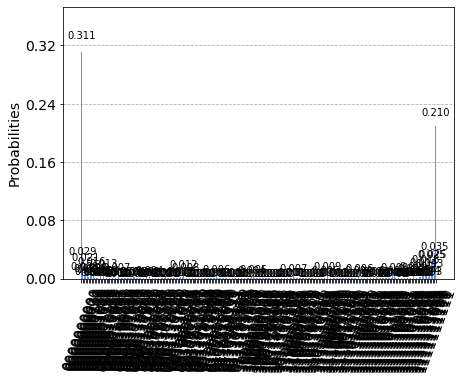

In [23]:
plot_histogram(real_result.get('quasi_dists'))